In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras 
import time
import matplotlib.pyplot as plt

In [2]:
def linalg_eigen(A, eigen):
    a, b = np.linalg.eig(A)
    val_vec_map = {}
    for k,val in enumerate(a):
        val_vec_map[val] = b[:,k]
    sort_orders = sorted(val_vec_map.items(), key=lambda v: v[0], reverse=True) # decreasing
    if eigen == "min":
        eigenval = sort_orders[-1][0]
        eigenvec = sort_orders[-1][1]
    if eigen == "max":
        eigenval = sort_orders[0][0]
        eigenvec = sort_orders[0][1]
    return (eigenval, eigenvec)

def plot_eigenvector(A,eigenvector_list,eigen="min"):
    val, vec = linalg_eigen(A, eigen)
        
    # normalize the eigenvector
    eigenvec_list_norm = []
    for i in range(len(eigenvector_list)):
        eigenvec_list_norm += [eigenvector_list[i]/np.linalg.norm(eigenvector_list[i])]
    
    # plot the neural network eigenvector
    for i in range(len(eigenvector_list[0])):
        plt.plot(np.array(eigenvec_list_norm)[:,i])
        
    # plot the actual eigenvector
    plt.plot([vec]*len(eigenvector_list),'--',color="black")
    
    plt.title('Convergence of the estimated eigenvector')
    plt.xlabel('Iteration')
    plt.margins(x=0)
    plt.show()

    
def plot_eigenvalues(A, eigenvalue_list, eigen="min"):
    val, vec = linalg_eigen(A, eigen)
    print(f'LA.{eigen} Eigenvalue',val)
    print(f'NN. {eigen} Eigenvalue',eigenvalue_list[-1])
    plt.plot(eigenvalue_list)
    plt.plot([val]*len(eigenvalue_list),'--')
    plt.title('Convergence of the estimated eigenvalue')
    plt.xlabel('Iteration')
    plt.margins(x=0)
    plt.show()

# Eigenvalues, eigenvector Solver

In [3]:
def mlp(x, weights):
    num_values = np.size(x)
    x = tf.constant(x, dtype=tf.float32)
    Z0 = tf.matmul(weights['W0'],x)
    X1 = tf.nn.sigmoid(Z0)
    Z1 = tf.matmul(weights['W1'],X1)
    return Z1

def calculate_eigenvalue(A, eta_max):
    num = np.dot(eta_max.T,np.dot(A,eta_max))
    dem = np.dot(eta_max.T,eta_max)
    lmbda_max = num/dem
    return lmbda_max

def g_trial(x, weights):
    return mlp(x, weights)

def g(x, g_trial, A):
    g_trial_transpose  = tf.transpose(g_trial)
    #print(g_trial.shape)
    xTA =g_trial_transpose@(A)
    right_matrix = (xTA@g_trial)*g_trial

    xTx = g_trial_transpose@g_trial 
    left_matrix = xTx*(A@g_trial)

    return (left_matrix - right_matrix)

def cost_function(x, A, weights): 
    with tf.GradientTape() as tape:
        t_i = tf.constant(x, name='X',dtype=tf.float32)
        tape.watch(t_i)
        g_t = g_trial(t_i, weights)
        dg_dt = tape.gradient(g_t,t_i)
        func = g(t_i, g_t, A)
    xTx = (g_t.numpy().T@g_t - 1)**2 
    xTAx = g_t.numpy().T@(A@g_t)
    return tf.reduce_mean((dg_dt-func)**2 + xTAx) + xTx
    #return tf.reduce_mean(xTAx) + xTx

def train_step(x, A, weights, optimizer):
    with tf.GradientTape() as tape:
        loss = cost_function(x, A, weights)
    trainable_variables = list(weights.values())
    gradient = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradient, trainable_variables))
    return loss

In [4]:
def eigensolver(A,iteration=10000,eigen="min",lr=0.001):
    print(f'Solving the {eigen} eigenvalues and eigenvector...')
    if eigen=="max":
        A = -1*A
    elif eigen=="min":
        A =  A 
        
    # parameters
    N, _ = np.shape(A)
    lr = 0.001
    hl = N
    hidden_layer = hl 
    learning_rate = lr 

    optimizer = tf.optimizers.SGD(learning_rate)
    x = np.random.random([N,1])

    weights={'W0':tf.Variable(tf.random.normal([hl, N]),name='W0'),
             'W1':tf.Variable(tf.random.normal([N,hl]),name='W1')}


    eigenvec_list = []
    eigenval_list = []
    for i in range(iteration):
        loss = train_step(x, A, weights, optimizer)
        res = g_trial(x, weights).numpy()
        eigenval_list += [calculate_eigenvalue(A,res)[0][0]]
        eigenvec_list+= [list(res.T[0])]
        if i % int(iteration*0.20) == 0:
            print(f"{i} iter loss: {loss}")
            
    print('NN eigenvalue = ',eigenval_list[-1])
    print('NN eigenvector= ',eigenvec_list[-1])
    
    if eigen == "min":
        eigenvec_list = -1*np.array(eigenvec_list)
    elif eigen == "max":
        eigenval_list = -1*np.array(eigenval_list)
        eigenvec_list = -1*np.array(eigenvec_list)
        
    return eigenval_list, eigenvec_list

# Application

## 3x3 symmetric matrix eigenvector and eigenvalues

In [5]:
A = np.array([[0.4035,0.2125,0.0954],
             [0.2125, 0.3703, 0.2216],
             [0.0954,0.2216,0.4159]])

# solve min eigenvalues and eigenvector 
min_eigval_list, min_eigvec_list = eigensolver(A,40000,'min')


# solve max eigenvalues and eigenvector 
max_eigval_list, max_eigvec_list = eigensolver(A,40000,'max')


np.savez(f'./data/eigenmin_list_3x3.npz', eigenvalues=min_eigval_list,eigenvector=min_eigvec_list)
np.savez(f'./data/eigenmax_list_3x3.npz', eigenvalues=max_eigval_list,eigenvector=max_eigvec_list)

Solving the min eigenvalues and eigenvector...
0 iter loss: [[4.5196295]]
8000 iter loss: [[0.14259212]]
16000 iter loss: [[0.12124977]]
24000 iter loss: [[0.12001844]]
32000 iter loss: [[0.11992257]]
NN eigenvalue =  0.12364437909922445
NN eigenvector=  [-0.4112296, 0.7658804, -0.42726585]
Solving the max eigenvalues and eigenvector...
0 iter loss: [[3.0382576]]
8000 iter loss: [[-0.8541334]]
16000 iter loss: [[-0.89229923]]
24000 iter loss: [[-0.89354146]]
32000 iter loss: [[-0.89357746]]
NN eigenvalue =  -0.7521470937624706
NN eigenvector=  [0.6296892, 0.7349804, 0.66284]


In [6]:
# Reference for the eigenvalue and eigenvector
a, b = np.linalg.eig(A)
print(a)
print(b)

[0.75214711 0.31412723 0.12342566]
[[-0.53657305 -0.72072449  0.43891408]
 [-0.62661084 -0.00807393 -0.77929049]
 [-0.56519751  0.69317459  0.44728152]]


LA.max Eigenvalue 0.7521471143758838
NN. max Eigenvalue 0.7521470937624706


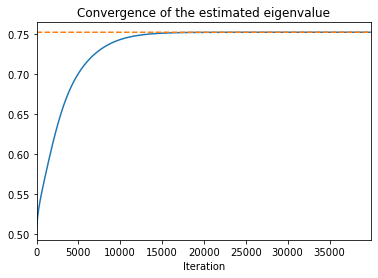

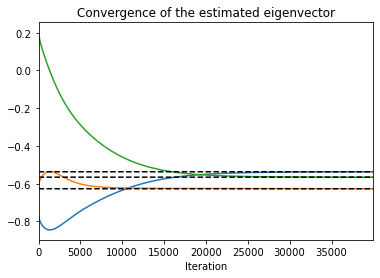

LA.min Eigenvalue 0.12342565761068812
NN. min Eigenvalue 0.12364437909922445


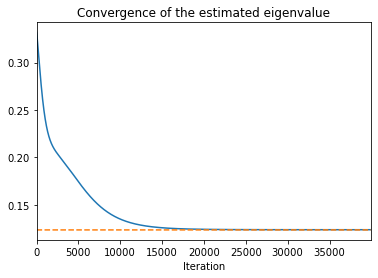

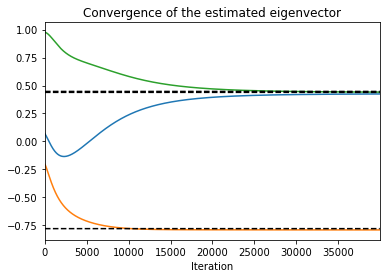

In [9]:
eigenmin_3x3 = np.load('./data/eigenmin_list_3x3.npz')
eigenmax_3x3 = np.load('./data/eigenmax_list_3x3.npz')
min_eigval_list, min_eigvec_list = eigenmin_3x3["eigenvalues"], eigenmin_3x3["eigenvector"]
max_eigval_list, max_eigvec_list = eigenmax_3x3["eigenvalues"], eigenmax_3x3["eigenvector"]

# Plot the max eigenvalue and eigenvector
plot_eigenvalues(A, max_eigval_list,"max")
plot_eigenvector(A,max_eigvec_list,"max")

# Plot the max eigenvalue and eigenvector
plot_eigenvalues(A, min_eigval_list,"min")
plot_eigenvector(A, min_eigvec_list,"min")

In [8]:
# accuracy calculation
max_val, max_vec = linalg_eigen(A, "max")
print('Max. eigenvalue Accuracy: ', abs(max_val-max_eigval_list[-1]))

min_val, min_vec = linalg_eigen(A, "min")
print('Min. eigenvalue Accuracy: ', abs(min_val-min_eigval_list[-1]))

Max. eigenvalue Accuracy:  2.0613413198589114e-08
Min. eigenvalue Accuracy:  0.00021872148853632756


## 5x5 symmetric matrix eigenvector and eigenvalues

In [602]:
B = np.array([[0.7663,0.4283,-0.3237,-0.4298,-0.1438],
                [0.4283, 0.2862, 0.0118, -0.2802, 0.1230],
                [-0.3237, 0.0118, -0.9093, -0.4384, 0.7684],
                [-0.4298, -0.2802, -0.4384, -0.0386, -0.1315],
                [-0.1438, 0.1230, 0.7684, -0.1315, -0.4480]])

# solve min eigenvalues and eigenvector
min_eigval_list, min_eigvec_list = eigensolver(B,40000,'min')

# solve max eigenvalues and eigenvector 
max_eigval_list, max_eigvec_list = eigensolver(B,40000,'max')

np.savez(f'./data/eigenmin_list_5x5.npz', eigenvalues=min_eigval_list,eigenvector=min_eigvec_list)
np.savez(f'./data/eigenmax_list_5x5.npz', eigenvalues=max_eigval_list,eigenvector=max_eigvec_list)

Solving the min eigenvalues and eigenvector...
0 iter loss: [[0.3944449]]
8000 iter loss: [[-2.1449745]]
16000 iter loss: [[-2.1701453]]
24000 iter loss: [[-2.1771605]]
32000 iter loss: [[-2.1797895]]
NN eigenvalue =  -1.5674652041072545
NN eigenvector=  [-0.13322237, -0.032666035, -1.0847237, -0.31632325, 0.7000312]
Solving the max eigenvalues and eigenvector...
0 iter loss: [[16.038681]]
8000 iter loss: [[-1.5905213]]
16000 iter loss: [[-1.6082742]]
24000 iter loss: [[-1.6091402]]
32000 iter loss: [[-1.6092342]]
NN eigenvalue =  -1.2306315421497034
NN eigenvector=  [-1.0276394, -0.5921102, 0.07685584, 0.44806522, 0.04527189]


In [603]:
# Reference for the eigenvalue and eigenvector
a, b = np.linalg.eig(B)
print(a)
print(b)

[-1.56887992  1.23063218 -0.48134608  0.51368892 -0.03749509]
[[-0.11591938  0.80867607 -0.36630714 -0.31481908  0.31514082]
 [-0.03697112  0.46592883  0.06476226  0.3081914  -0.82605531]
 [-0.81391888 -0.06018593 -0.16545258  0.52208713  0.18429373]
 [-0.22777979 -0.35227801 -0.66454556 -0.46070518 -0.41248819]
 [ 0.52043083 -0.0350885  -0.6266016   0.56664166  0.1191982 ]]


LA.max Eigenvalue 1.2306321750841391
NN. max Eigenvalue 1.2306315421497034


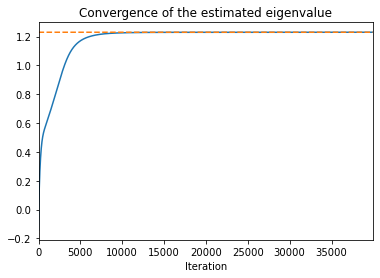

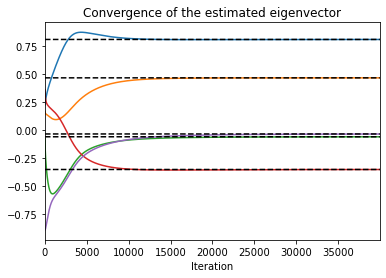

LA.min Eigenvalue -1.5688799230636756
NN. min Eigenvalue -1.5674652041072545


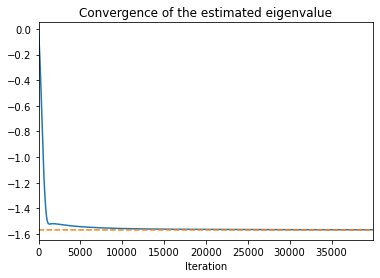

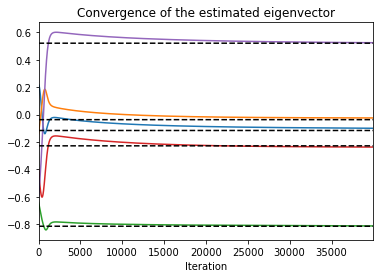

In [617]:
eigenmin_5x5 = np.load('./data/eigenmin_list_5x5.npz')
eigenmax_5x5 = np.load('./data/eigenmax_list_5x5.npz')
min_eigval_list, min_eigvec_list = eigenmin_5x5["eigenvalues"], eigenmin_5x5["eigenvector"]
max_eigval_list, max_eigvec_list = eigenmax_5x5["eigenvalues"], eigenmax_5x5["eigenvector"]

# Plot the max eigenvalue and eigenvector
plot_eigenvalues(B, max_eigval_list,"max")
plot_eigenvector(B, max_eigvec_list,"max")

# Plot the max eigenvalue and eigenvector
plot_eigenvalues(B, min_eigval_list,"min")
plot_eigenvector(B, -min_eigvec_list,"min")

In [605]:
# accuracy calculation 
max_val, max_vec = linalg_eigen(B, "max")
print('Max. eigenvalue Accuracy: ', abs(max_val-max_eigval_list[-1]))

min_val, min_vec = linalg_eigen(B, "min")
print('Min. eigenvalue Accuracy: ', abs(min_val-min_eigval_list[-1]))

Max. eigenvalue Accuracy:  6.329344357514088e-07
Min. eigenvalue Accuracy:  0.0014147189564210905


## 6x6 symmetric matrix eigenvectors and eigenvalues

Solving the min eigenvalues and eigenvector...
0 iter loss: [[2.7023654]]
8000 iter loss: [[-0.39884102]]
16000 iter loss: [[-0.40559655]]
24000 iter loss: [[-0.4063546]]
32000 iter loss: [[-0.40659475]]
NN eigenvalue =  -0.3724131754816129
NN eigenvector=  [0.24164693, -0.5883891, 0.49859124, 0.29656485, -0.020373285, -0.6675092]
Solving the max eigenvalues and eigenvector...
0 iter loss: [[181.66736]]
8000 iter loss: [[-5.89007]]
16000 iter loss: [[-5.956361]]
24000 iter loss: [[-5.973059]]
32000 iter loss: [[-5.9786224]]
NN eigenvalue =  -3.2842744646016033
NN eigenvector=  [-0.5585141, -0.6587091, -0.7782975, -0.6772436, -0.7960575, -0.44616178]


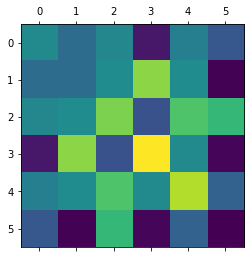

In [606]:
np.random.seed(2021)
Q = np.random.randint(1,3, size=(6,6))
Q = np.random.random(size=(6,6))
C = (Q.T + Q)/2
plt.matshow(C)

# solve min eigenvalues and eigenvector 
min_eigval_list, min_eigvec_list = eigensolver(C,40000,'min')

# solve max eigenvalues and eigenvector 
max_eigval_list, max_eigvec_list = eigensolver(C,40000,'max')

np.savez(f'./data/eigenmin_list_6x6.npz', eigenvalues=min_eigval_list,eigenvector=min_eigvec_list)
np.savez(f'./data/eigenmax_list_6x6.npz', eigenvalues=max_eigval_list,eigenvector=max_eigvec_list)

In [607]:
C

array([[0.57430429, 0.47743243, 0.56213709, 0.25145943, 0.53906801,
        0.41596295],
       [0.47743243, 0.47631347, 0.5806496 , 0.84741961, 0.58200561,
        0.20563261],
       [0.56213709, 0.5806496 , 0.82801437, 0.39706174, 0.76671426,
        0.7207461 ],
       [0.25145943, 0.84741961, 0.39706174, 0.98177009, 0.57562394,
        0.21573423],
       [0.53906801, 0.58200561, 0.76671426, 0.57562394, 0.89065539,
        0.44821454],
       [0.41596295, 0.20563261, 0.7207461 , 0.21573423, 0.44821454,
        0.20132266]])

In [608]:
# Reference for the eigenvalue and eigenvector
a, b = np.linalg.eig(C)
print(a)
print(b)

[ 3.28486352  0.85950834 -0.37266674 -0.14326618  0.18080714  0.1431342 ]
[[ 0.34848128  0.28579018  0.21304784  0.19414681  0.82010177 -0.20306526]
 [ 0.40438098 -0.3225718  -0.53602352 -0.61730648  0.24324245  0.06977154]
 [ 0.47683534  0.38928454  0.45794556 -0.33618441 -0.25851527  0.48116667]
 [ 0.41641184 -0.73124015  0.27113532  0.42342432 -0.04513506  0.19248202]
 [ 0.48288705  0.10911707 -0.02575231  0.02710289 -0.42969871 -0.75423792]
 [ 0.28475631  0.34074956 -0.61919119  0.53683987 -0.12148212  0.34124902]]


LA.max Eigenvalue 3.2848635223670897
NN. max Eigenvalue 3.2842744646016033


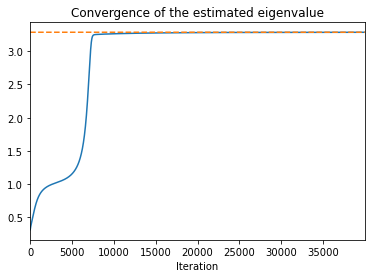

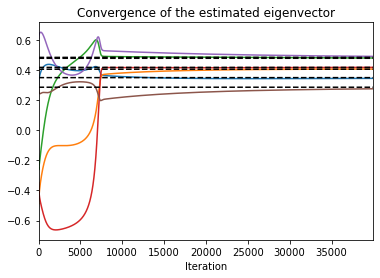

LA.min Eigenvalue -0.3726667399968084
NN. min Eigenvalue -0.3724131754816129


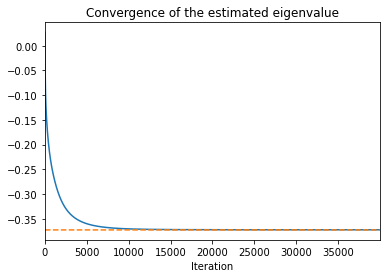

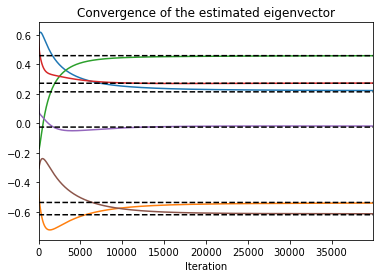

In [618]:
eigenmin_6x6 = np.load('./data/eigenmin_list_6x6.npz')
eigenmax_6x6 = np.load('./data/eigenmax_list_6x6.npz')
min_eigval_list, min_eigvec_list = eigenmin_6x6["eigenvalues"], eigenmin_6x6["eigenvector"]
max_eigval_list, max_eigvec_list = eigenmax_6x6["eigenvalues"], eigenmax_6x6["eigenvector"]


# Plot the max eigenvalue and eigenvector
plot_eigenvalues(C, max_eigval_list,"max")
plot_eigenvector(C, max_eigvec_list,"max")

# Plot the max eigenvalue and eigenvector
plot_eigenvalues(C, min_eigval_list,"min")
plot_eigenvector(C, -min_eigvec_list,"min")

In [610]:
# accuracy calculation
max_val, max_vec = linalg_eigen(C, "max")
print('Max. eigenvalue Accuracy: ', abs(max_val-max_eigval_list[-1]))

min_val, min_vec = linalg_eigen(C, "min")
print('Min. eigenvalue Accuracy: ', abs(min_val-min_eigval_list[-1]))

Max. eigenvalue Accuracy:  0.0005890577654863449
Min. eigenvalue Accuracy:  0.0002535645151954813


## 7x7 symmetric matrix eigenvector and eigenvalues

In [611]:
D = np.array([[0.6037,0.5587,-0.3907,0.1629,-0.2079,0.3688,0.3990],
            [0.5587,0.9918,-0.1018,0.4110,0.1256,-0.2908,-0.0014],
            [-0.3907,-0.1018,-0.3977,-0.2967,0.0273,-0.3578,0.2106],
            [0.1629,0.4110,-0.2967,-0.9101,0.6153,0.3519,-0.3277],
            [-0.2079,0.1256,0.0273,0.6153,-0.8451,-0.0503,-0.7252],
            [0.3688,-0.2908,-0.3578,0.3519,-0.0503,0.3475,0.1201],
            [0.3990,-0.0014,0.2106, -0.3277, -0.7252, 0.1201, -0.9565]])

# solve min eigenvalues and eigenvector 
min_eigval_list, min_eigvec_list = eigensolver(D,40000,'min')

# solve max eigenvalues and eigenvector 
max_eigval_list, max_eigvec_list = eigensolver(D,40000,'max')

np.savez(f'./data/eigenmin_list_7x7.npz', eigenvalues=min_eigval_list,eigenvector=min_eigvec_list)
np.savez(f'./data/eigenmax_list_7x7.npz', eigenvalues=max_eigval_list,eigenvector=max_eigvec_list)

Solving the min eigenvalues and eigenvector...
0 iter loss: [[504.1345]]
8000 iter loss: [[-2.4877775]]
16000 iter loss: [[-2.4980624]]
24000 iter loss: [[-2.5020647]]
32000 iter loss: [[-2.5043833]]
NN eigenvalue =  -1.7451061656105766
NN eigenvector=  [0.06401479, -0.035427302, 0.2575118, 0.5685816, -0.9560196, -0.04641694, -0.74967563]
Solving the max eigenvalues and eigenvector...
0 iter loss: [[1238.3243]]
8000 iter loss: [[-2.147333]]
16000 iter loss: [[-2.1604538]]
24000 iter loss: [[-2.1646557]]
32000 iter loss: [[-2.1664228]]
NN eigenvalue =  -1.5594324250693228
NN eigenvector=  [-0.8162243, -0.96221447, 0.27954516, -0.25847125, -0.027637064, -0.1925559, -0.0727199]


In [612]:
# Reference for the eigenvalue and eigenvector
a, b = np.linalg.eig(D)
print(a)
print(b)

[ 1.55982969  0.95411742  0.46806406 -0.34735853 -0.64836991 -1.74608037
 -1.40660237]
[[-0.61388025 -0.39069549 -0.32897709 -0.47972678 -0.33725284  0.04981023
  -0.1261896 ]
 [-0.71827342  0.53710773  0.02815058  0.40642676  0.11956491 -0.03233516
  -0.11950765]
 [ 0.20968211  0.22528924 -0.26484436  0.33935798 -0.82614208  0.19052272
  -0.03409026]
 [-0.20110197  0.00925312  0.45817846 -0.09668534 -0.17676156  0.38685361
   0.74786126]
 [-0.01373481  0.17545873  0.50430177 -0.25634502 -0.3822375  -0.70533046
  -0.07345736]
 [-0.13968238 -0.6702246   0.37896447  0.58246689 -0.09951456 -0.03062797
  -0.19381655]
 [-0.05590994 -0.16746546 -0.46149457  0.27420277  0.04691168 -0.55864983
   0.60528891]]


LA.max Eigenvalue 1.5598296875275834
NN. max Eigenvalue 1.5594324250693228


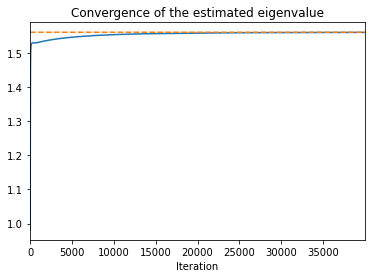

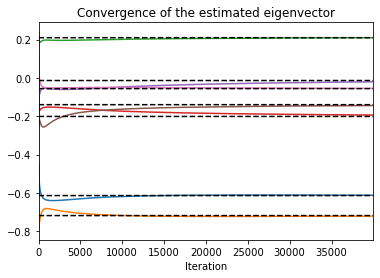

LA.min Eigenvalue -1.7460803664812041
NN. min Eigenvalue -1.7451061656105766


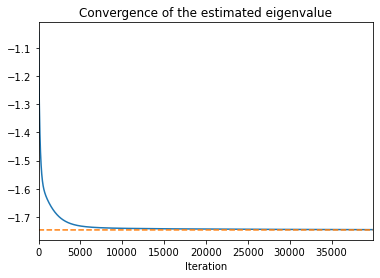

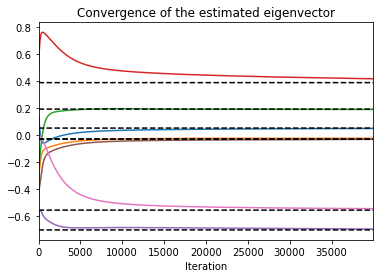

In [619]:
eigenmin_7x7 = np.load('./data/eigenmin_list_7x7.npz')
eigenmax_7x7 = np.load('./data/eigenmax_list_7x7.npz')
min_eigval_list, min_eigvec_list = eigenmin_7x7["eigenvalues"], eigenmin_7x7["eigenvector"]
max_eigval_list, max_eigvec_list = eigenmax_7x7["eigenvalues"], eigenmax_7x7["eigenvector"]


# Plot the max eigenvalue and eigenvector
plot_eigenvalues(D, max_eigval_list,"max")
plot_eigenvector(D, -max_eigvec_list,"max")

# Plot the max eigenvalue and eigenvector
plot_eigenvalues(D, min_eigval_list,"min")
plot_eigenvector(D, -min_eigvec_list,"min")

In [620]:
# accuracy calculation
max_val, max_vec = linalg_eigen(D, "max")
print('Max. eigenvalue Accuracy: ', abs(max_val-max_eigval_list[-1]))

min_val, min_vec = linalg_eigen(D, "min")
print('Min. eigenvalue Accuracy: ', abs(min_val-min_eigval_list[-1]))

Max. eigenvalue Accuracy:  0.000397262458260661
Min. eigenvalue Accuracy:  0.0009742008706274952
